# Tutorial: Braking behavior analysis.

In [120]:
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# whether use Chinese
CHN = False 
if CHN:
    plt.rcParams['axes.unicode_minus'] = False
    plt.rcParams['font.sans-serif'] = ['SimSun']
else:
    plt.rcParams['font.sans-serif'] = ['Arial']
    
# colors
BLUE = '#2878B5'
LIGHTBLUE = '#9AC9DB'
ORANGE = '#F8AC8C'
RED = '#C82423'
PINK = '#FF8884'
GREY = '#9E9E9E'
DEEPGREEN = '#32B897'
GREEN = '#96CCCB'

LABEL_FONT = {
    "fontsize": 12,
    "weight": "bold",
}
plt.rcParams['figure.dpi'] = 150


## Trip aggregation data

In [121]:
import pickle
with open("Z://Data/NEE_Chengdu/agg/agg_trip_20161120.pkl", 'rb') as f:
    agg_trip = pickle.load(f)

agg_trip = agg_trip[agg_trip['mileage'] <= 0.6].copy()
agg_trip = agg_trip[agg_trip['brakeCount'] > 0].copy()
agg_trip = agg_trip[agg_trip['brakeEventNum'] > 0].copy()
agg_trip.shape

(1108626, 24)

In [122]:
agg_trip.columns

Index(['vehID', 'startHour', 'trajCount', 'brakeCount', 'idlingCount',
       'brakeEventNum', 'mileage', 'speed_mean', 'speed_std', 'acc_mean',
       'acc_std', 'decel_mean', 'decel_std', 'VSP_mean', 'VSP_std',
       'initSpeed_mean', 'brakeDecel_mean', 'brakeDecel_std', 'grade_mean',
       'grade_std', 'OpModeCount', 'brakeFrac', 'idlingFrac', 'brakingFreq'],
      dtype='object')

Cleaning

mileage               Axes(0.125,0.11;0.0731132x0.77)
speed_mean         Axes(0.212736,0.11;0.0731132x0.77)
initSpeed_mean     Axes(0.300472,0.11;0.0731132x0.77)
acc_mean           Axes(0.388208,0.11;0.0731132x0.77)
brakeDecel_mean    Axes(0.475943,0.11;0.0731132x0.77)
VSP_mean           Axes(0.563679,0.11;0.0731132x0.77)
grade_mean         Axes(0.651415,0.11;0.0731132x0.77)
brakeFrac          Axes(0.739151,0.11;0.0731132x0.77)
brakingFreq        Axes(0.826887,0.11;0.0731132x0.77)
dtype: object

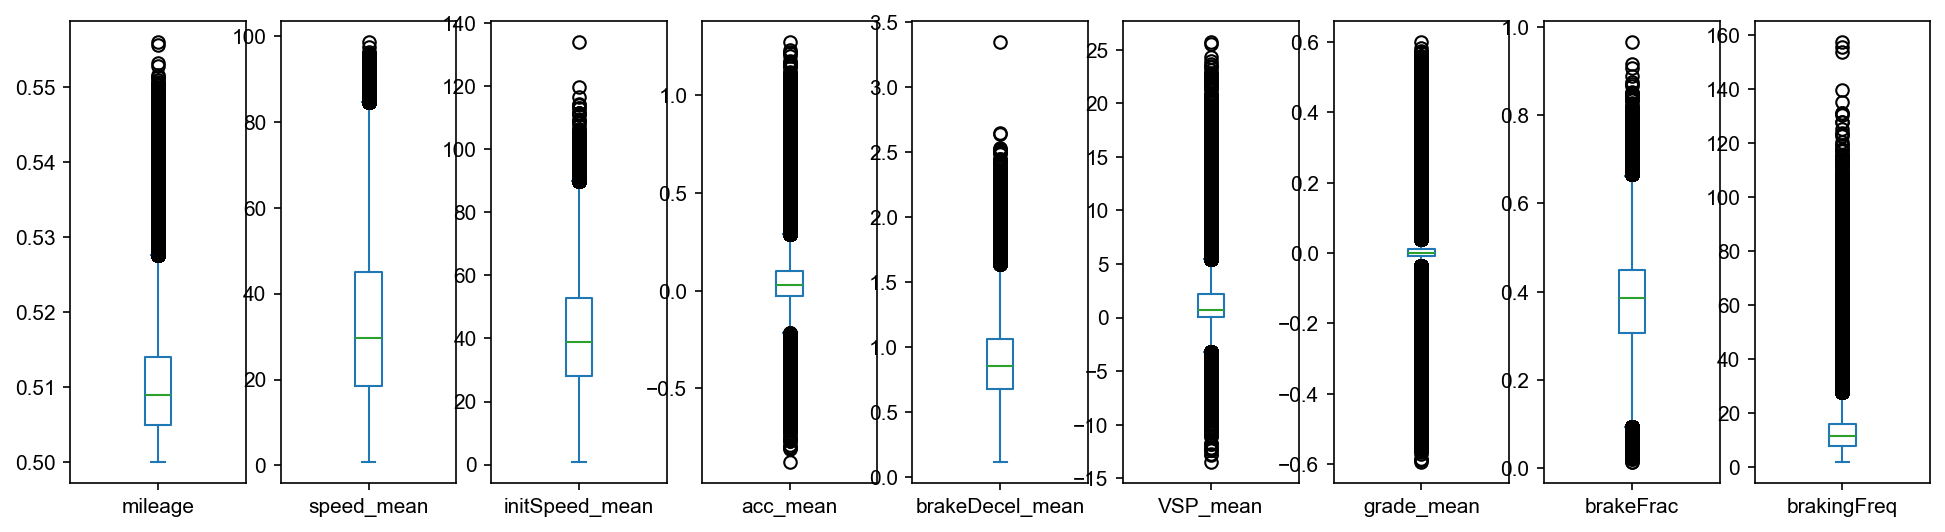

In [123]:
agg_trip[['mileage', 'speed_mean', 'initSpeed_mean', 'acc_mean', 'brakeDecel_mean', 'VSP_mean', 'grade_mean', 'brakeFrac', 'brakingFreq']].plot(kind='box', subplots=True, sharex=False, figsize=(16,4))

In [124]:
agg_trip = agg_trip[agg_trip['initSpeed_mean'] <= 120].copy()
agg_trip = agg_trip[agg_trip['acc_mean'] >= -1].copy()
agg_trip = agg_trip[agg_trip['brakeDecel_mean'] <= 3].copy()
agg_trip = agg_trip[(agg_trip['VSP_mean'] >= -15) & (agg_trip['VSP_mean'] <= 25)].copy()
agg_trip = agg_trip[agg_trip['brakingFreq'] <= 140].copy()

In [125]:
agg_trip.shape

(1108619, 24)

In [134]:
# obtain bins for ER
speedBins = np.arange(0, 110, 10)
initSpeedBins = np.arange(0, 140, 20)
accBins = np.arange(-10, 16, 5) / 10
VSPBins = np.arange(-15, 30, 5)
decelBins = np.arange(0, 2.5, 0.3)
brakeDecelBins = np.arange(0, 2.8, 0.3)
brakeFracBins = np.arange(0, 1.2, 0.2)
idleFracBins = np.arange(0, 1.2, 0.2)
gradeBins = np.arange(-2, 2, 1) / 100

## Emission calculation

In [127]:
OpModeERs = np.load("./data/agg/OpModeERs.npy")
agg_trip['ER'] = agg_trip.apply(lambda x: sum(x['OpModeCount'] / x['trajCount'] * OpModeERs), axis=1)  # g/hr/veh
agg_trip['EF'] = agg_trip.apply(lambda x: x['ER'] * (x['trajCount'] / 3600) / x['mileage'], axis=1)  # g/km/veh

In [137]:
# with open("Z:/Data/NEE_Chengdu/agg/agg_trip_data.pkl", 'wb') as f:
#     pickle.dump(agg_trip, f)

ER       Axes(0.125,0.11;0.352273x0.77)
EF    Axes(0.547727,0.11;0.352273x0.77)
dtype: object

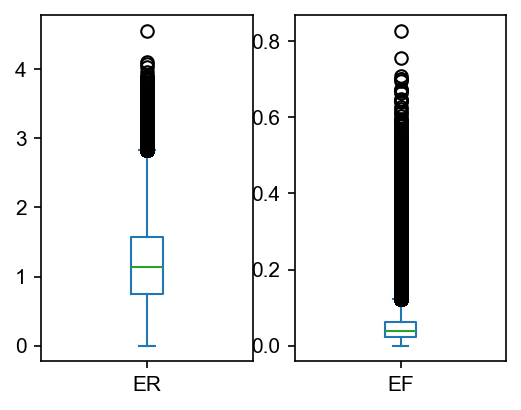

In [128]:
agg_trip[['ER', 'EF']].plot(kind='box', subplots=True, sharex=False, figsize=(4,3))

## Relational analysis

In [129]:
def binCal(xCol, yCol, bins, aggFile=agg_trip):
    mean = [aggFile[(aggFile[xCol] >= minV) & (aggFile[xCol] < maxV)][yCol].mean() for minV, maxV in zip(bins[:-1], bins[1:])]
    std = [aggFile[(aggFile[xCol] >= minV) & (aggFile[xCol] < maxV)][yCol].std() for minV, maxV in zip(bins[:-1], bins[1:])]
    
    return mean, std

In [130]:
def distPlot(ax, xCol, binwidth, color, xLabel, subID, aggFile=agg_trip, hline=True):
    sns.histplot(
        aggFile, y=xCol, binwidth=binwidth, stat='proportion',
        element='bars', fill=False, hatch='//', color=color, alpha=0.6, ax=ax
    )
    if hline:
        ax.hlines(
            aggFile[xCol].mean(), 0, ax.get_xbound()[1],
            colors='k', linestyles='dashed',
            label='Mean = %.2f' % aggFile[xCol].mean()
        )
        ax.legend()
    ax.set_xlabel("Proportion\n(%s)"%(subID), fontdict=LABEL_FONT)
    ax.set_ylabel(xLabel, fontdict=LABEL_FONT)

    return ax

In [131]:
def corrPlot(ax, xCol, yCol, bins, binMean, binStd, xLabel, yLabel, subID, cmap, aggFile=agg_trip, histBinNum=30):
    # hist plot
    sns.histplot(
        aggFile, x=xCol, y=yCol, bins=histBinNum, stat='proportion', ax=ax,
        fill=True, cmap=cmap, cbar=True, cbar_kws=dict(location='right', shrink=0.8, label="Proportion"),
        )
    ax.errorbar(
        bins[:-1]+(bins[1]-bins[0])/2, binMean, binStd,
        color='k', linestyle='dotted', linewidth=1, marker='d', alpha=0.5,
        label="Average"
    )
    ax.set_xticks(bins)
    ax.set_xlabel("%s\n(%s)"%(xLabel, subID), fontdict=LABEL_FONT)
    ax.set_ylabel(yLabel, fontdict=LABEL_FONT)
    ax.legend()
    ax.grid(axis='x', linestyle=":")

    return ax

### ER vs vars

In [135]:
# obtain bins for ER
ER_speed_mean, ER_speed_std = binCal('speed_mean', 'ER', speedBins)
ER_acc_mean, ER_acc_std = binCal('acc_mean', 'ER', accBins)
ER_VSP_mean, ER_VSP_std = binCal('VSP_mean', 'ER', VSPBins)
ER_brakeDecel_mean, ER_brakeDecel_std = binCal('brakeDecel_mean', 'ER', brakeDecelBins)
ER_brakeFrac_mean, ER_brakeFrac_std = binCal('brakeFrac', 'ER', brakeFracBins)
ER_idleFrac_mean, ER_idleFrac_std = binCal('idlingFrac', 'ER', idleFracBins)
ER_initSpeed_mean, ER_initSpeed_std = binCal('initSpeed_mean', 'ER', initSpeedBins)

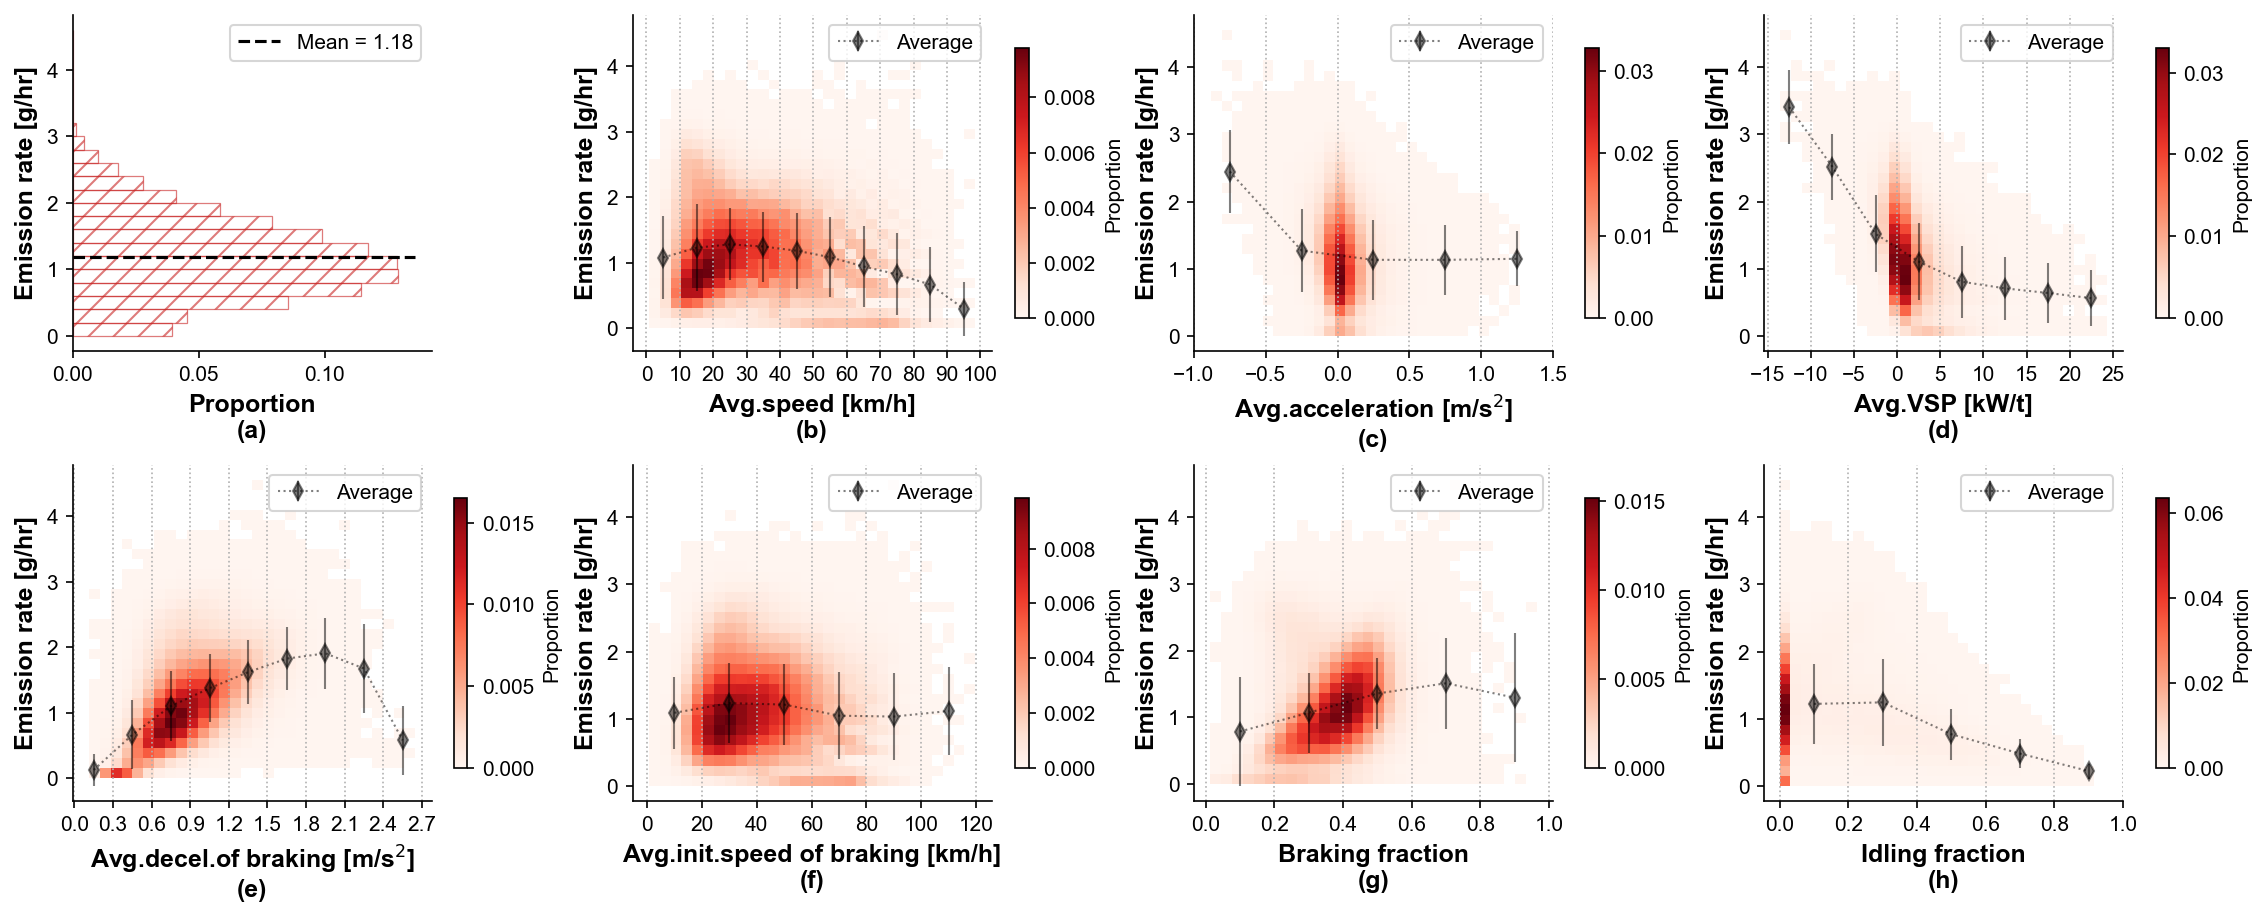

In [136]:
fig, ax = plt.subplots(2, 4, figsize=(15,6), constrained_layout=True)
ax = ax.flatten()

# ER dist
ax[0] = distPlot(
    ax[0], xCol='ER', xLabel='Emission rate [g/hr]',
    subID='a', binwidth=0.2, color=RED, 
)

# speed - ER
ax[1] = corrPlot(
    ax[1], xCol='speed_mean', yCol='ER', xLabel="Avg.speed [km/h]", yLabel="Emission rate [g/hr]",
    bins=speedBins, binMean=ER_speed_mean, binStd=ER_speed_std,
    subID='b', cmap='Reds'
)

# acc - ER
ax[2] = corrPlot(
    ax[2], xCol='acc_mean', yCol='ER', xLabel="Avg.acceleration [m/s$^2$]", yLabel="Emission rate [g/hr]",
    bins=accBins, binMean=ER_acc_mean, binStd=ER_acc_std,
    subID='c', cmap='Reds'
)

# VSP - ER
ax[3] = corrPlot(
    ax[3], xCol='VSP_mean', yCol='ER', xLabel="Avg.VSP [kW/t]", yLabel="Emission rate [g/hr]",
    bins=VSPBins, binMean=ER_VSP_mean, binStd=ER_VSP_std,
    subID='d', cmap='Reds'
)

# brake decel - ER
ax[4] = corrPlot(
    ax[4], xCol='brakeDecel_mean', yCol='ER', xLabel="Avg.decel.of braking [m/s$^2$]", yLabel="Emission rate [g/hr]",
    bins=brakeDecelBins, binMean=ER_brakeDecel_mean, binStd=ER_brakeDecel_std,
    subID='e', cmap='Reds'
)

# grade - ER
ax[5] = corrPlot(
    ax[5], xCol='initSpeed_mean', yCol='ER', xLabel="Avg.init.speed of braking [km/h]", yLabel="Emission rate [g/hr]",
    bins=initSpeedBins, binMean=ER_initSpeed_mean, binStd=ER_initSpeed_std,
    subID='f', cmap='Reds'
)

# brakeFrac - ER
ax[6] = corrPlot(
    ax[6], xCol='brakeFrac', yCol='ER', xLabel="Braking fraction", yLabel="Emission rate [g/hr]",
    bins=brakeFracBins, binMean=ER_brakeFrac_mean, binStd=ER_brakeFrac_std,
    subID='g', cmap='Reds'
)

# idleFrac - ER
ax[7] = corrPlot(
    ax[7], xCol='idlingFrac', yCol='ER', xLabel="Idling fraction", yLabel="Emission rate [g/hr]",
    bins=idleFracBins, binMean=ER_idleFrac_mean, binStd=ER_idleFrac_std,
    subID='h', cmap='Reds'
)

for ax_ in ax:
    ax_.spines['top'].set_visible(False)
    ax_.spines['right'].set_visible(False)

plt.show()

### Braking params

In [223]:
brakeFrac_initSpeed_mean, brakeFrac_initSpeed_std =binCal('initSpeed_mean', 'brakeFrac', initSpeedBins)
brakeDecel_initSpeed_mean, brakeDecel_initSpeed_std =binCal('initSpeed_mean', 'brakeDecel_mean', initSpeedBins)
brakeFrac_brakeDecel_mean, brakeFrac_brakeDecel_std =binCal('brakeDecel_mean', 'brakeFrac', brakeDecelBins)

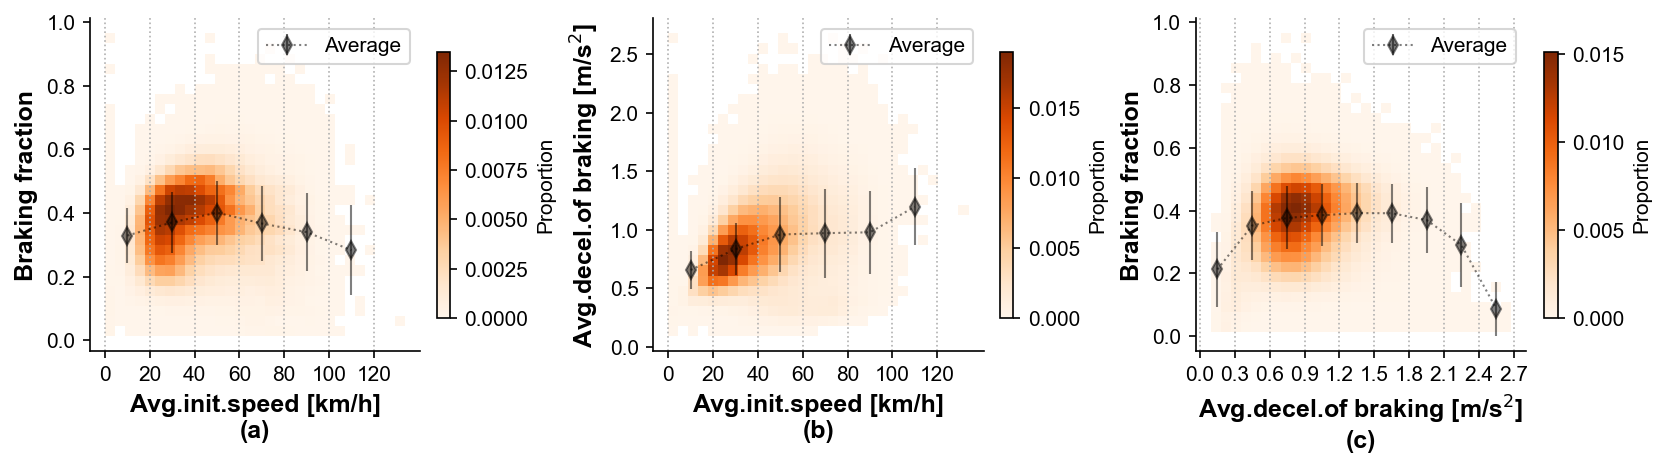

In [224]:
fig, ax = plt.subplots(1,3,figsize=(11,3), constrained_layout=True)
ax = ax.flatten()

ax[0] = corrPlot(
    ax[0], 'initSpeed_mean', 'brakeFrac', xLabel='Avg.init.speed [km/h]', yLabel='Braking fraction', bins=initSpeedBins,
    binMean=brakeFrac_initSpeed_mean, binStd=brakeFrac_initSpeed_std,
    subID='a', cmap='Oranges'
)

ax[1] = corrPlot(
    ax[1], 'initSpeed_mean', 'brakeDecel_mean', xLabel='Avg.init.speed [km/h]', yLabel='Avg.decel.of braking [m/s$^2$]', bins=initSpeedBins,
    binMean=brakeDecel_initSpeed_mean, binStd=brakeDecel_initSpeed_std,
    subID='b', cmap='Oranges'
)

ax[2] = corrPlot(
    ax[2], 'brakeDecel_mean', 'brakeFrac', xLabel='Avg.decel.of braking [m/s$^2$]', yLabel='Braking fraction', bins=brakeDecelBins,
    binMean=brakeFrac_brakeDecel_mean, binStd=brakeFrac_brakeDecel_std,
    subID='c', cmap='Oranges'
)

for ax_ in ax:
    ax_.spines['top'].set_visible(False)
    ax_.spines['right'].set_visible(False)

plt.show()

In [225]:
brakeFrac_speed_mean, brakeFrac_speed_std =binCal('speed_mean', 'brakeFrac', speedBins)
brakeDecel_speed_mean, brakeDecel_speed_std =binCal('speed_mean', 'brakeDecel_mean', speedBins)
brakeFrac_brakeDecel_mean, brakeFrac_brakeDecel_std =binCal('brakeDecel_mean', 'brakeFrac', brakeDecelBins)

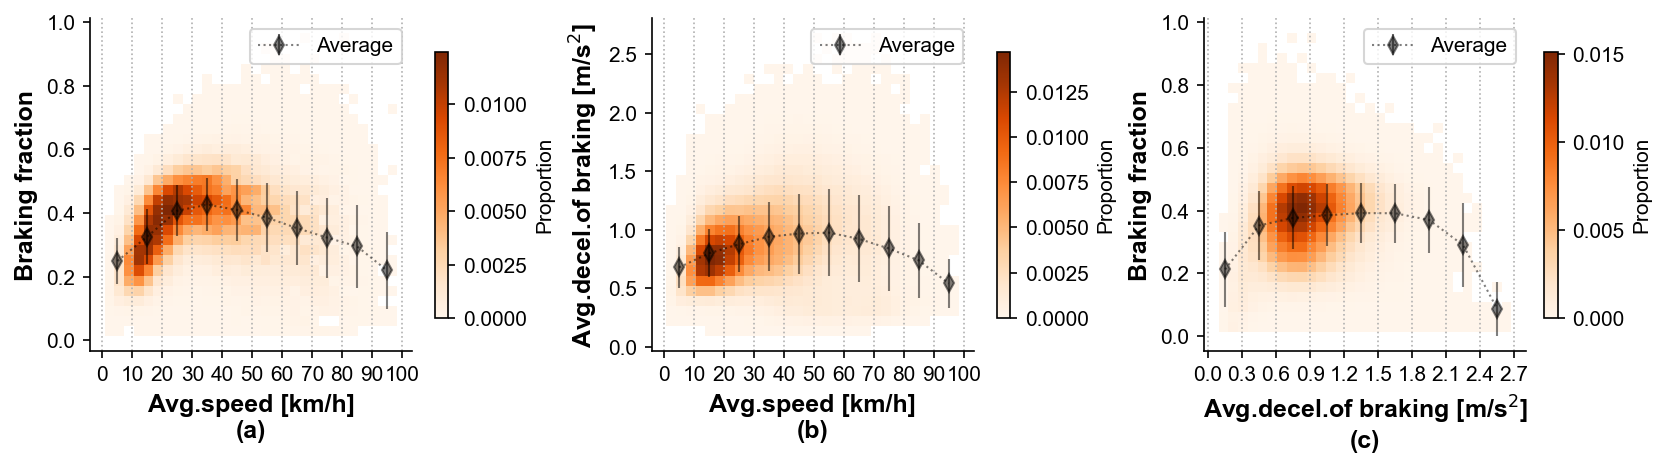

In [226]:
fig, ax = plt.subplots(1,3,figsize=(11,3), constrained_layout=True)
ax = ax.flatten()

ax[0] = corrPlot(
    ax[0], 'speed_mean', 'brakeFrac', xLabel='Avg.speed [km/h]', yLabel='Braking fraction', bins=speedBins,
    binMean=brakeFrac_speed_mean, binStd=brakeFrac_speed_std,
    subID='a', cmap='Oranges'
)

ax[1] = corrPlot(
    ax[1], 'speed_mean', 'brakeDecel_mean', xLabel='Avg.speed [km/h]', yLabel='Avg.decel.of braking [m/s$^2$]', bins=speedBins,
    binMean=brakeDecel_speed_mean, binStd=brakeDecel_speed_std,
    subID='b', cmap='Oranges'
)

ax[2] = corrPlot(
    ax[2], 'brakeDecel_mean', 'brakeFrac', xLabel='Avg.decel.of braking [m/s$^2$]', yLabel='Braking fraction', bins=brakeDecelBins,
    binMean=brakeFrac_brakeDecel_mean, binStd=brakeFrac_brakeDecel_std,
    subID='c', cmap='Oranges'
)

for ax_ in ax:
    ax_.spines['top'].set_visible(False)
    ax_.spines['right'].set_visible(False)

plt.show()

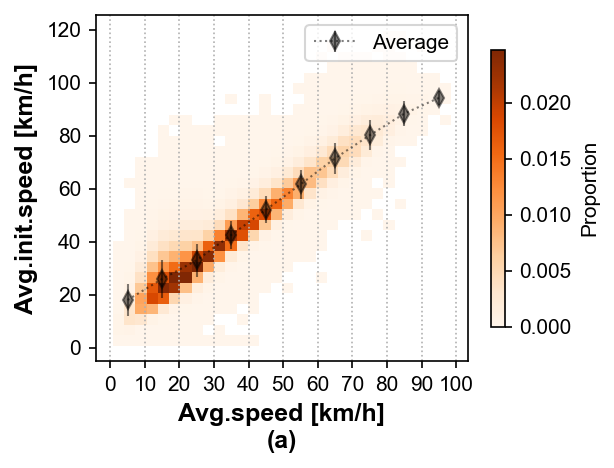

In [116]:
initSpeed_speed_mean, initSpeed_speed_std = binCal('speed_mean', 'initSpeed_mean', speedBins, aggFile=agg_trip)
fig, ax = plt.subplots(1,1, figsize=(4,3))
ax = corrPlot(
    ax, 'speed_mean', 'initSpeed_mean', speedBins, xLabel='Avg.speed [km/h]', yLabel='Avg.init.speed [km/h]',
    binMean=initSpeed_speed_mean, binStd=initSpeed_speed_std, subID='a', cmap='Oranges', aggFile=agg_trip
)

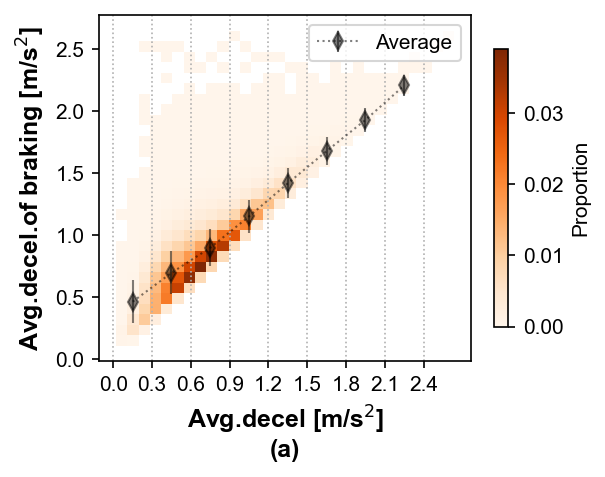

In [140]:
brakeDecel_decel_mean, brakeDecel_decel_std = binCal('decel_mean', 'brakeDecel_mean', decelBins, aggFile=agg_trip)
fig, ax = plt.subplots(1,1, figsize=(4,3))
ax = corrPlot(
    ax, 'decel_mean', 'brakeDecel_mean', decelBins, xLabel='Avg.decel [m/s$^2$]', yLabel='Avg.decel.of braking [m/s$^2$]',
    binMean=brakeDecel_decel_mean, binStd=brakeDecel_decel_std, subID='a', cmap='Oranges', aggFile=agg_trip
)

## Temporal variation

In [142]:
hourBins = np.arange(0, 25, 3)
speed_hour_mean, speed_hour_std = binCal('startHour', 'speed_mean', hourBins)
acc_hour_mean, acc_hour_std = binCal('startHour', 'acc_mean', hourBins)
brakeDecel_hour_mean, brakeDecel_hour_std = binCal('startHour', 'brakeDecel_mean', hourBins)
brakeFrac_hour_mean, brakeFrac_hour_std = binCal('startHour', 'brakeFrac', hourBins)
idleFrac_hour_mean, idleFrac_hour_std = binCal('startHour', 'idlingFrac', hourBins)

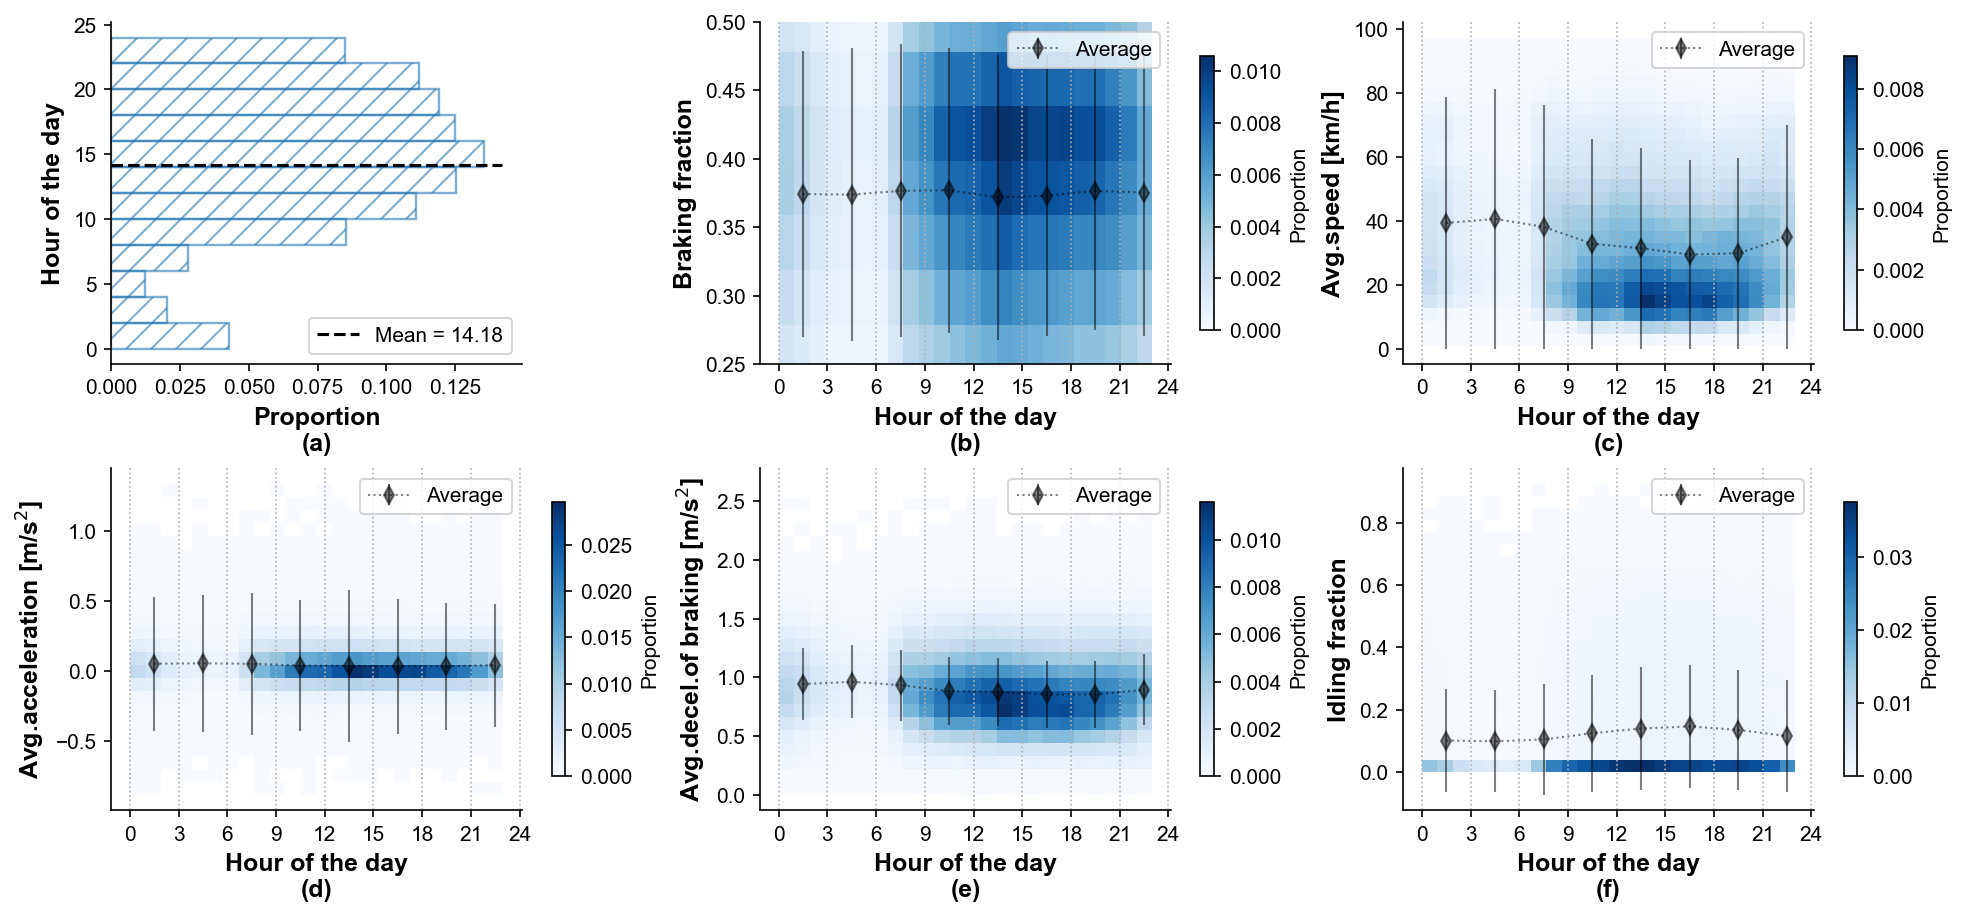

In [144]:
fig, ax = plt.subplots(2, 3, figsize=(13,6), constrained_layout=True)
ax = ax.flatten()

# ER dist
ax[0] = distPlot(
    ax[0], xCol='startHour', xLabel='Hour of the day',
    subID='a', binwidth=2, color=BLUE, 
)

# hour-brakeFrac
ax[1] = corrPlot(
    ax[1], xCol='startHour', yCol='brakeFrac', xLabel="Hour of the day", yLabel="Braking fraction",
    bins=hourBins, binMean=brakeFrac_hour_mean, binStd=brakeFrac_hour_std,
    subID='b', cmap='Blues', histBinNum=24
)
ax[1].set_ylim(0.25, 0.5)

# hour-speed
ax[2] = corrPlot(
    ax[2], xCol='startHour', yCol='speed_mean', xLabel="Hour of the day", yLabel="Avg.speed [km/h]",
    bins=hourBins, binMean=speed_hour_mean, binStd=speed_hour_mean,
    subID='c', cmap='Blues', histBinNum=24
)

# hour-acc
ax[3] = corrPlot(
    ax[3], xCol='startHour', yCol='acc_mean', xLabel="Hour of the day", yLabel="Avg.acceleration [m/s$^2$]",
    bins=hourBins, binMean=acc_hour_mean, binStd=ER_VSP_std,
    subID='d', cmap='Blues', histBinNum=24
)

# hour-decel of braking
ax[4] = corrPlot(
    ax[4], xCol='startHour', yCol='brakeDecel_mean', xLabel="Hour of the day", yLabel="Avg.decel.of braking [m/s$^2$]",
    bins=hourBins, binMean=brakeDecel_hour_mean, binStd=brakeDecel_hour_std,
    subID='e', cmap='Blues', histBinNum=24
)

# hour-idling fraction
ax[5] = corrPlot(
    ax[5], xCol='startHour', yCol='idlingFrac', xLabel="Hour of the day", yLabel="Idling fraction",
    bins=hourBins, binMean=idleFrac_hour_mean, binStd=idleFrac_hour_std,
    subID='f', cmap='Blues', histBinNum=24
)

for ax_ in ax:
    ax_.spines['top'].set_visible(False)
    ax_.spines['right'].set_visible(False)

plt.show()

In [228]:
agg_trip.columns

Index(['vehID', 'startHour', 'trajCount', 'brakeCount', 'idlingCount',
       'brakeEventNum', 'mileage', 'speed_mean', 'speed_std', 'acc_mean',
       'acc_std', 'decel_mean', 'decel_std', 'VSP_mean', 'VSP_std',
       'initSpeed_mean', 'brakeDecel_mean', 'brakeDecel_std', 'grade_mean',
       'grade_std', 'OpModeCount', 'brakeFrac', 'idlingFrac', 'brakingFreq',
       'ER', 'EF'],
      dtype='object')

## Modeling

In [141]:
import pickle
with open("Z:/Data/NEE_Chengdu/agg/agg_trip_data.pkl", 'rb') as f:
    agg_trip = pickle.load(f)

In [142]:
data = agg_trip[[
    'speed_mean', 'speed_std',
    'acc_mean', 'acc_std',
    'VSP_mean', 'VSP_std',
    'brakeDecel_mean', 'brakeFrac', 'brakingFreq', 'initSpeed_mean',
    'grade_mean', 'grade_std', 'idlingFrac',
    'ER'
]]
data.reset_index(drop=True, inplace=True)

<Axes: >

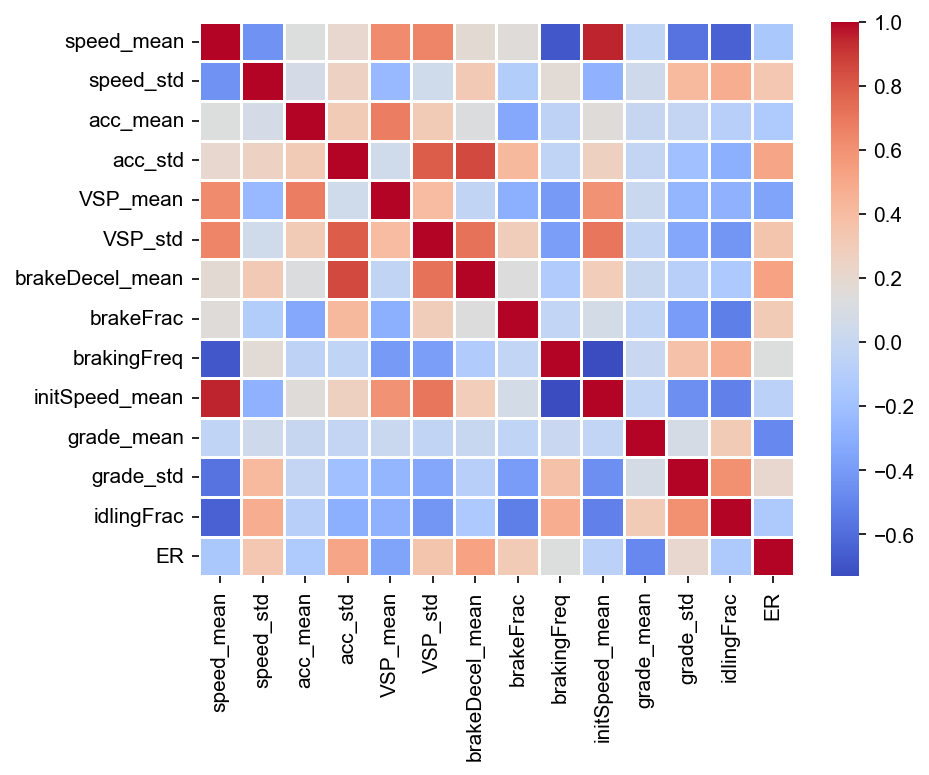

In [143]:
sns.heatmap(
    data.corr(),
    linewidths=0.5,
    cbar=True, cmap='coolwarm'
)

### Data

In [178]:
data = agg_trip[[
    'speed_mean', 'speed_std',
    'acc_mean', 'acc_std',
    'VSP_mean', 'VSP_std',
    'brakeDecel_mean', 'brakeFrac', 'brakingFreq', 'initSpeed_mean',
    'grade_mean', 'grade_std', 'idlingFrac',
    'ER'
]].sample(10000)
data.reset_index(drop=True, inplace=True)

In [179]:
from sklearn.model_selection import train_test_split
X, Y = data.iloc[:, :-1], data['ER']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print('X training:', X_train.shape, 'X testing:', X_test.shape)

X training: (8000, 13) X testing: (2000, 13)


### Tuning

Parameters of XGBoost:
- General params:
  - `n_estimators`
  - `eta`: learning rate
- Tree booster params:
  - `gamma`: minimum loss reduction required to make a partition. The larger gamma is, the more conservative the algorithm will be (default=0, range[0,inf]).
  - `max_depth`: max depth of a tree (default=6, range[0,inf]).
  - `min_child_weight`: minimum sum of instance weight (hessian) needed in a child. The larger `min_child_weight` is, the more conservative the algorithm will be (default=1, range[0, inf]).
  - `subsample`: subsample ratio of the training instances (0,1].
  - `colsample_bytree`: the subsample ratio of columns when constructing each tree. (0,1].

Performance metrics:
- `RMSE`
- `R2`

In [185]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

Step1: tuning tree-based params

In [196]:
# XGBoost
import xgboost as xgb
best_params = {}

# set param grid
params = {
    'max_depth': [6, 7, 8],
    'min_child_weight': [1, 3, 5],
}
# initialize regressor and gridsearch
reg = xgb.XGBRegressor(
    eta=0.1, n_estimators=50, seed=42
)
gs = GridSearchCV(
    reg, param_grid=params, scoring='r2', cv=10, verbose=1,
).fit(X_train, y_train)

# update best params
best_params.update(gs.best_params_)

# output info
y_pred = gs.best_estimator_.predict(X_test)
print("Best params:", gs.best_params_, "\nValidate R2: %.3f" % gs.best_score_)
print("Test R2: %.3f" % r2_score(y_test, y_pred))
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(y_test, y_pred)))

Fitting 10 folds for each of 9 candidates, totalling 90 fits
Best params: {'max_depth': 7, 'min_child_weight': 3}
R2: 0.866
RMSE: 0.228


Step2: tuning gamma

In [197]:
# set param grid
params = {
    'gamma': [0, 1, 2, 3],
}
# initialize regressor and gridsearch
reg = xgb.XGBRegressor(
    eta=0.1, n_estimators=50, seed=42,
    max_depth=best_params['max_depth'], min_child_weight=best_params['min_child_weight'],
)
gs = GridSearchCV(
    reg, param_grid=params, scoring='r2', cv=10, verbose=1,
).fit(X_train, y_train)

# update best params
best_params.update(gs.best_params_)

# output info
y_pred = gs.best_estimator_.predict(X_test)
print("Best params:", gs.best_params_, "\nValidate R2: %.3f" % gs.best_score_)
print("Test R2: %.3f" % r2_score(y_test, y_pred))
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(y_test, y_pred)))

Fitting 10 folds for each of 4 candidates, totalling 40 fits


Best params: {'gamma': 0}
R2: 0.866
RMSE: 0.228


Step3: tuning `subsample` and `colsample_bytree`

In [198]:
# set param grid
params = {
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}
# initialize regressor and gridsearch
reg = xgb.XGBRegressor(
    eta=0.1, n_estimators=50, seed=42,
    max_depth=best_params['max_depth'], min_child_weight=best_params['min_child_weight'],
    gamma=best_params['gamma']
)
gs = GridSearchCV(
    reg, param_grid=params, scoring='r2', cv=10, verbose=1,
).fit(X_train, y_train)

# update best params
best_params.update(gs.best_params_)

# output info
y_pred = gs.best_estimator_.predict(X_test)
print("Best params:", gs.best_params_, "\nValidate R2: %.3f" % gs.best_score_)
print("Test R2: %.3f" % r2_score(y_test, y_pred))
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(y_test, y_pred)))

Fitting 10 folds for each of 9 candidates, totalling 90 fits
Best params: {'colsample_bytree': 1.0, 'subsample': 1.0}
R2: 0.866
RMSE: 0.228


Step4: tuning `eta` and `n_estimators`

In [204]:
# set param grid
params = {
    'eta': [0.01, 0.05],
    'n_estimators': [500, 1000],
}
# initialize regressor and gridsearch
reg = xgb.XGBRegressor(
    eta=0.1, n_estimators=50, seed=42,
    max_depth=best_params['max_depth'], min_child_weight=best_params['min_child_weight'],
    gamma=best_params['gamma'],
    subsample=best_params['subsample'], colsample_bytree=best_params['colsample_bytree']
)
gs = GridSearchCV(
    reg, param_grid=params, scoring='r2', cv=10, verbose=1,
).fit(X_train, y_train)

# update best params
best_params.update(gs.best_params_)

# output info
y_pred = gs.best_estimator_.predict(X_test)
print("Best params:", gs.best_params_, "\nValidate R2: %.3f" % gs.best_score_)
print("Test R2: %.3f" % r2_score(y_test, y_pred))
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(y_test, y_pred)))

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Best params: {'eta': 0.01, 'n_estimators': 1000} 
Validate R2: 0.855
R2: 0.868
RMSE: 0.226


In [205]:
best_params

{'max_depth': 7,
 'min_child_weight': 3,
 'gamma': 0,
 'colsample_bytree': 1.0,
 'subsample': 1.0,
 'eta': 0.01,
 'n_estimators': 1000}

### Save

In [199]:
# bst.save_model('model_file_name.json')